In [33]:
!ls

imagenes_tarea3_2022.zip  sample_data


In [34]:
!unzip /content/imagenes_tarea3_2022.zip

Archive:  /content/imagenes_tarea3_2022.zip
   creating: car_side/
 extracting: car_side/image_0001.jpg  
  inflating: car_side/image_0002.jpg  
 extracting: car_side/image_0003.jpg  
 extracting: car_side/image_0004.jpg  
 extracting: car_side/image_0005.jpg  
 extracting: car_side/image_0006.jpg  
 extracting: car_side/image_0007.jpg  
 extracting: car_side/image_0008.jpg  
 extracting: car_side/image_0009.jpg  
 extracting: car_side/image_0010.jpg  
 extracting: car_side/image_0011.jpg  
 extracting: car_side/image_0012.jpg  
 extracting: car_side/image_0013.jpg  
 extracting: car_side/image_0014.jpg  
 extracting: car_side/image_0015.jpg  
 extracting: car_side/image_0016.jpg  
 extracting: car_side/image_0017.jpg  
 extracting: car_side/image_0018.jpg  
 extracting: car_side/image_0019.jpg  
 extracting: car_side/image_0020.jpg  
 extracting: car_side/image_0021.jpg  
 extracting: car_side/image_0022.jpg  
 extracting: car_side/image_0023.jpg  
 extracting: car_side/image_0024.jpg

In [35]:
!pwd


/content


In [549]:
#    Para utilizar la interpolacion normal: Interpolacion = 0 
#    Para utilizar la interpolacion bilinear: Interpolacion = 1

interpolacion = 1
gridsearch = True
binario = True

In [509]:
import cv2
import numpy as np

In [510]:
def transform(img):
    #transforma la imagen a escala de grises, al tipo np.float32
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #redimensiona la imagen a tamaño 64x128
    gray32 = np.float32(gray)
    out = cv2.resize(gray32, (64,128), interpolation = cv2.INTER_AREA)
    return out

In [511]:
example = cv2.imread('pedestrian/1.png')
out = transform(example)
print("shape",out.shape)
out

shape (128, 64)


array([[19.      , 19.      , 19.      , ..., 19.      , 24.444445,
        26.      ],
       [19.      , 19.      , 19.      , ..., 18.422222, 24.31605 ,
        26.      ],
       [19.      , 19.      , 19.      , ..., 18.155556, 24.256792,
        26.      ],
       ...,
       [73.844444, 74.25432 , 75.68889 , ..., 76.17778 , 70.97531 ,
        69.48889 ],
       [75.68889 , 76.039505, 77.26666 , ..., 68.51111 , 66.679016,
        66.155556],
       [78.      , 78.22222 , 79.      , ..., 61.      , 64.111115,
        65.      ]], dtype=float32)

2. Implementar en python una función que reciba una imagen y calcule sus gradientes (se
puede reutilizar código de cálculo de gradientes de la tarea 2).


In [512]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [513]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] gradx(np.ndarray[np.float32_t, ndim=2] input):
  # POR HACER: calcular el gradiente en x
  cdef int rows,cols, i,j

  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  for i in range(rows):
    for j in range(2,cols-2): 
        output[i][j-2] = -1*input[i][j-2]+0*input[i][j-1]+1*input[i][j]
        
  return output

In [514]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] grady(np.ndarray[np.float32_t, ndim=2] input):
  # POR HACER: Calcular el gradiente en y
  cdef int rows,cols, i,j
  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  for j in range(cols):
    for i in range(2,rows-2): 
        output[i-2][j] = -1*input[i-2][j]+0*input[i-1][j]+1*input[i][j]
        
  return output

In [515]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef MagDir(np.ndarray[np.float32_t, ndim=2] dx,np.ndarray[np.float32_t, ndim=2] dy):

    cdef int rows,cols, i,j
    cdef np.ndarray[np.float32_t, ndim=2] magnitud = np.zeros([dx.shape[0], dx.shape[1]], dtype = np.float32)
    cdef np.ndarray[np.float32_t, ndim=2] angulo = np.zeros([dx.shape[0], dx.shape[1]], dtype = np.float32)

    rows = dx.shape[0]
    cols = dx.shape[1]
    for i in range(rows):
        for j in range(cols):
            magnitud[i][j] = np.sqrt(dx[i][j]**2+dy[i][j]**2)
            # Angulo en grados para simplificar los futuros histogramas
            angulo[i][j] = np.degrees(np.arctan2(dx[i][j],dy[i][j]))

            #los angulos deben quedar en el rango de 0° a 180°
            if angulo[i][j]>=180:
                angulo[i][j] = angulo[i][j] - 180
    return magnitud,angulo

4. Implementar en python el block normalization para el histograma. Para implementar esto,
se deben formar bloques de 2x2 celdas (con traslape). Cada bloque se debe transformar en
un vector de 1x36, el cual se debe normalizar. El vector de características final (de tamaño
1x3780) se obtiene concatenando los vectores normalizados de cada bloque.

In [516]:
def block_normalization(histogram):
    """
    Implementar en python el block normalization para el histograma. Para implementar esto,
    se deben formar bloques de 2x2 celdas (con traslape). Cada bloque se debe transformar en
    un vector de 1x36, el cual se debe normalizar. El vector de características final (de tamaño
    1x3780) se obtiene concatenando los vectores normalizados de cada bloque
    """
    output = np.array([], np.float32)
    for i in range(16-1):
        for j in range(8-1):

            L = np.concatenate((histogram[i][j],histogram[i][j+1],histogram[i+1][j],histogram[i+1][j+1]))
            if sum(L)!=0:
                output= np.concatenate((output,L/sum(L)))
            else:
                output= np.concatenate((output,L))
    
    return np.array(output,np.float32)



def HOG(dx,dy,interpolacion=0):
    """3. Implementar en python una función que, a partir de los gradientes, calcule las
    características HOG usando 8x16 celdas (la salida debe ser un arreglo de numpy de
    dimensión 8x16x9).
    
    Para esto:
    1. se determinan 2 matrices, una de la magnitud de las derivadas y otra
    de las direcciones de estas.
    2. Se dividen las matrices en 8x16 celdas.
    3. En cada celda se calcula un histograma de orientación del gradiente
    con 9 componentes, es decir, se realiza un histograma el cual separa los angulos
    en 9 intervalos cubriendo cada uno 20°, luego por cada pixel de la celda se agregan 
    los valores de la magnitud proporcionales a la distancia del angulo a los intervalos
    más cercanos, de esta manera los votos que se agregan son proporcionales a las distancias.
    4. Luego se reunen los histogramas de orientación del gradiente de cada celda
    los cuales corresponden a los features que retorna este método. Esto se reune
    en un arrelgo de numpy de dimensión 8x16x9.

    Para utilizar la interpolacion normal: Interpolacion = 0 
    Para utilizar la interpolacion bilinear: Interpolacion = 1
    """
    histograms = np.zeros([16,8,9],np.float32)

    #utilizamos una función auxiliar para determinar la magnitud y el angulo
    magnitud, angulo = MagDir(dx,dy)    
    rows = dx.shape[0]
    cols = dx.shape[1]
    
    for i in range(rows):
        for j in range(cols):
            cont1 = i//8
            cont2 = j//8
            #creamos un arreglo que guarde los valores del respectivo histograma
            bins = np.array([0,20,40,60,80,100,120,140,160])
            bin = int(np.floor(angulo[i][j]/20))
            if bin>8:
                bin=8
            p = angulo[i][j]/20-np.floor(angulo[i][j]/20)
            if interpolacion == 0: #lineal
                
                if angulo[i][j]%20==0:
                    histograms[cont1][cont2][bin] += magnitud[i][j]
                elif bin==8:
                    histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                else:
                    histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                    histograms[cont1][cont2][bin+1] += (p)*magnitud[i][j]
            
            else: #bilinearly
                """
                Determinamos las posiciones de los centros de las 4 celdas más cercanas que conforman un bloque,
                luego a partir de la distancia del pixel con esas 4 celdas se distribuyen 8 votos, los cuales corresponden
                a 2 votos por celda: 1 voto al bin correspondiente y otro voto al siguiente bin.
                """
                
                #listas que guardan las 4 celdas más cercanas y sus respectivos posiciones de sus centros
                celdas = [ (cont1,cont2),(cont1,cont2+1),(cont1+1,cont2),(cont1+1,cont2+1) ]
                centros = [((cont1*8+8)/2,(cont2*8+8)/2) ,((cont1*8+8)/2,((cont2+2)*8+8)/2), (((cont1+2)*8+8)/2,(cont2*8+8)/2),(((cont1+2)*8+8)/2,((cont2+2)*8+8)/2)]
                
                #Zona normal
                if celdas[0][0]!=15 and celdas[0][1]!=7:

                    # si estamos en el centro, todos los votos van para esa celda.
                    if i==centros[0][0] and j==centros[0][1]:
                        if angulo[i][j]%20==0:
                            histograms[cont1][cont2][bin] += magnitud[i][j]
                        elif bin==8:
                            histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                        else:
                            histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                            histograms[cont1][cont2][bin+1] += (p)*magnitud[i][j]
                    

                    distancias = []
                    for k in range(4):
                        #determinamos la distancia al centro de la celda px,py
                        px=centros[k][0]
                        py=centros[k][1]

                        d = np.sqrt((i-px)**2+(j-py)**2)
                        distancias.append(d)

                    pd = np.array(distancias,np.float32)/sum(distancias)

                    for k in range(4):
                        c1 = celdas[k][0]
                        c2 = celdas[k][1]
                        #print(pd[3-k],celdas[k])     
                        if angulo[i][j]%20==0:
                            histograms[c1][c2][bin] += magnitud[i][j]*pd[3-k]*0.25
                        elif bin==8:
                            histograms[c1][c2][bin] += (1-p)*magnitud[i][j]*pd[3-k]*0.25
                        else:
                            histograms[c1][c2][bin] += (1-p)*magnitud[i][j]*pd[3-k]*0.25
                            histograms[c1][c2][bin+1] += (p)*magnitud[i][j]*pd[3-k]*0.25

                #Zonas bordes
                else:
                    if angulo[i][j]%20==0:
                        histograms[cont1][cont2][bin] += magnitud[i][j]
                    elif bin==8:
                        histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                    else:
                        histograms[cont1][cont2][bin] += (1-p)*magnitud[i][j]
                        histograms[cont1][cont2][bin+1] += (p)*magnitud[i][j]

            

    features = block_normalization(histograms)

    return features

In [517]:

#Pruebas
i=125
j=62
cont1 =i//8
cont2 = j//8
print("celda:",cont1,cont2)
celdas = [ (cont1,cont2),(cont1,cont2+1),(cont1+1,cont2),(cont1+1,cont2+1) ]
centros = [((cont1*8+8)/2,(cont2*8+8)/2) ,((cont1*8+8)/2,((cont2+2)*8+8)/2), (((cont1+2)*8+8)/2,(cont2*8+8)/2),(((cont1+2)*8+8)/2,((cont2+2)*8+8)/2)]

distancias = []
for k in range(4):
    #determinamos la distancia al centro de la celda px,py
    px=centros[k][0]
    py=centros[k][1]
    

    d = np.sqrt((i-px)**2+(j-py)**2)
    distancias.append(d)

p = np.array(distancias,np.float32)/sum(distancias)


for k in range(4):
    print(p[3-k],celdas[k][0],celdas[k][1])


celda: 15 7
0.2285239 15 7
0.24252929 15 8
0.25823715 16 7
0.27070963 16 8


In [518]:
dx = gradx(out)
print(dx.shape)
dy = grady(out)
result = HOG(dx,dy)
result

(128, 64)


array([0.        , 0.        , 0.        , ..., 0.01848958, 0.00235616,
       0.0141345 ], dtype=float32)

In [519]:
result.shape

(3780,)

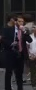

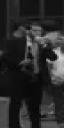

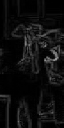

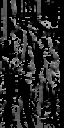

In [520]:
from google.colab.patches import cv2_imshow
cv2_imshow(example)
cv2_imshow(out)
dx = gradx(out)
dy = grady(out)
magnitud, angulo = MagDir(dx,dy)    
cv2_imshow(magnitud)
cv2_imshow(angulo)

In [521]:
example.shape

(90, 36, 3)

In [522]:
out.shape

(128, 64)

5. Extraer características HOG de cada imagen del conjunto de entrenamiento. Se recomienda
aplicar un StandardScaler (usando scikit-learn) a las características para normalizarlas. El
StandardScaler se debe entrenar usando sólo las características de entrenamiento.


In [523]:
import os

def cargarDatos(nombre_carpeta,clase):
    data = []
    contenido = os.listdir(nombre_carpeta)
    label = []
    for nombre_imagen in contenido: 
        img = cv2.imread(os.path.join(nombre_carpeta, nombre_imagen))
        imgt = transform(img)
        data.append(imgt)
        label.append(clase)

    return np.array(data),np.array(label)

In [524]:
def featureExtractor(data,interpolacion=0):
    """
    Para utilizar la interpolacion normal: Interpolacion = 0 
    Para utilizar la interpolacion bilinear: Interpolacion = 1
    """
    features = []
    for img in data:
        dx = gradx(img)
        dy = grady(img)
        feature = HOG(dx,dy,interpolacion)
        features.append(feature)
    #caracteristicas no normalizadas
    return np.array(features)

In [550]:
#Carga todos los datos de la carpeta "car_side" y le asigna la clase 0
dataCar_side,CSlabel = cargarDatos("car_side",0)
if binario==True:
    label_2 = 0
    text_labels = ["Cars/Chairs","pedestrian"]
else:
    label_2 = 1
    text_labels = ["Cars", "Chairs", "Pedestrian"]

#Carga todos los datos de la carpeta "chair" y le asigna la clase 1
dataChair,CL = cargarDatos("chair",label_2)

#Carga todos los datos de la carpeta "pedestrian" y le asigna la clase 2
dataPedestrian,PL = cargarDatos("pedestrian",2)

print("car_side.   ","shape = ",dataCar_side.shape, ", clase = ","0")
print("chair.      ","shape = ",dataChair.shape,  " , clase = ","1")
print("pedestrian. ","shape = ",dataPedestrian.shape, ", clase = ","2\n")

car_side.    shape =  (123, 128, 64) , clase =  0
chair.       shape =  (62, 128, 64)  , clase =  1
pedestrian.  shape =  (185, 128, 64) , clase =  2



In [526]:
#data no normalizada
data = np.concatenate((dataCar_side,dataChair,dataPedestrian))
labels = np.concatenate((CSlabel,CL,PL))
data.shape

(370, 128, 64)

In [527]:
#Caracteristicas no normalizadas
features = featureExtractor(data,interpolacion=interpolacion)

In [528]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  PredefinedSplit

In [529]:

# Conjuntos de Train y Val/Test
X_trainval, X_test, y_trainval, y_test = train_test_split(features, labels, test_size=0.2, shuffle = True, stratify = labels)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, shuffle = False,test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_trainval = scaler.transform(X_trainval)
X_test = scaler.transform(X_test)

split_fold = [-1 for _ in range(int(len(X_trainval)*0.75))]+ [0 for _ in range(int(len(X_trainval)*0.25))]
cv = PredefinedSplit(split_fold)

In [530]:
X_train.shape

(222, 3780)

In [531]:
X_val.shape

(74, 3780)

In [532]:
X_test.shape

(74, 3780)

6. Entrenar un SVM (usando scikit-learn) con las características extraídas a cada imagen
redimensionada del conjunto de entrenamiento. Se debe elegir un kernel y usar grid
search, usando el conjunto de validación para encontrar los mejores hiper parámetros (se
debe usar PredefinedSplit).

# SVM

In [533]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Create the parameter grid based on the results of random search 

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['scale','auto',1,0.1],
              'kernel': ['linear','rbf', 'poly', 'sigmoid'],
              'class_weight':('balanced',None),
              'decision_function_shape':['ovo','ovr']} 
# Instantiate the grid search model
grid = GridSearchCV(SVC(), param_grid,cv=cv, refit=False)

In [536]:
if gridsearch == False:
    classifier = SVC(C=0.1, class_weight='balanced', decision_function_shape='ovo',
    gamma= 'scale',kernel='linear')
else:
    # fitting the model for grid search
    grid.fit(X_trainval, y_trainval)
    print(grid.best_params_)
    classifier = SVC(C=0.1, class_weight='balanced', decision_function_shape='ovo',
    gamma= 'scale',kernel='linear')

{'C': 0.1, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}


In [552]:
#classifier = SVC(C=0.1, class_weight='balanced', decision_function_shape='ovo',
#    gamma= 'scale',kernel='linear')
# Interpolacion normal
#classifier = SVC(C=1, class_weight='balanced', decision_function_shape='ovo',
#    gamma= 'scale',kernel='rbf')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(y_pred)

[2 0 2 0 2 2 2 0 2 2 0 2 2 0 0 0 0 2 0 0 2 2 0 2 2 2 2 2 2 0 0 0 0 2 0 0 2
 0 0 0 0 2 2 2 2 0 0 2 0 2 0 2 2 2 0 0 0 0 0 2 2 0 0 2 2 2 2 2 0 2 2 0 0 0]


Classification accuracy is 98.648649 %
Classification recall is 98.648649 %



<Figure size 864x648 with 0 Axes>

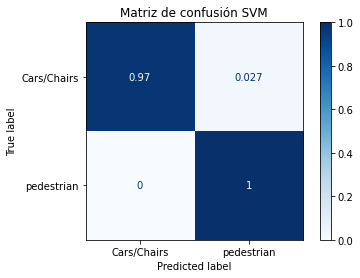

In [553]:
# calculate accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import  accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import ConfusionMatrixDisplay


accuracy = accuracy_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred, average='macro')*100
print("Classification accuracy is %2f"%accuracy,"%")
print("Classification recall is %2f"%recall,"%\n")

fig = plt.figure(figsize = (12,9))



ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test,display_labels=text_labels, normalize="true",cmap=plt.cm.Blues)
t = plt.title("Matriz de confusión SVM")

# Random Forest

In [539]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False,True],
    'max_depth': [30, 50, 90, 100],
    'max_features': [5,10,15,20,25,30],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30,60,100,200]
}
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 3)

In [540]:
if gridsearch == False:
    classifierRF = RandomForestClassifier(bootstrap=False, max_depth=90, max_features=30,
                       min_samples_leaf=3, min_samples_split=8)
else:
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    #se revisan los mejores hiperparametros encontrados
    classifierRF = grid_search.best_estimator_


Se han truncado las últimas 5000 líneas del flujo de salida.
[CV 2/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=60;, score=0.986 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=60;, score=0.959 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=100;, score=0.959 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=100;, score=0.946 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=100;, score=0.986 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=0.959 total time=   0.3s
[CV 2/3] END bootstrap=False,

In [554]:
#classifierRF = best_grid
#RandomForestClassifier(bootstrap=False, max_depth=100, max_features=25,
#                       min_samples_leaf=4, min_samples_split=10)
#RandomForestClassifier(bootstrap=False, max_depth=90, max_features=30,
#                       min_samples_leaf=3, min_samples_split=8)
classifierRF.fit(X_train, y_train)
y_pred = classifierRF.predict(X_test)
print(y_pred)

[2 0 2 2 2 2 2 0 2 2 0 2 2 0 0 0 2 2 0 0 2 2 0 2 2 2 2 2 2 0 0 0 0 2 0 0 2
 0 0 0 0 2 2 2 2 0 0 2 0 2 0 2 2 2 0 0 0 0 0 2 2 0 0 2 2 2 2 2 0 2 2 0 0 0]


Classification accuracy is 95.945946 %
Classification recall is 95.945946 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x648 with 0 Axes>

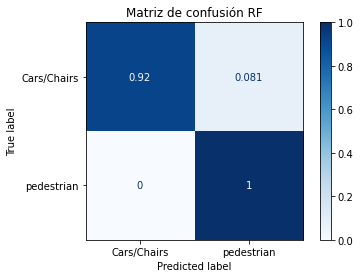

In [555]:
# calculate accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import  accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix

accuracy = accuracy_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred, average='macro')*100
print("Classification accuracy is %2f"%accuracy,"%")
print("Classification recall is %2f"%recall,"%")

plt.figure(figsize = (12,9))
plot_confusion_matrix(classifierRF, X_test, y_test,display_labels=text_labels,cmap=plt.cm.Blues, normalize="true") 
t = plt.title("Matriz de confusión RF")